In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import tensorflow as tf

In [2]:
model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

(raw_train_images, train_labels), (raw_test_images, test_labels) = mnist.load_data()
train_images = raw_train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = raw_test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

model.fit(train_images, train_labels, epochs=5, batch_size=128)

2021-12-28 21:21:24.560175: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-28 21:21:24.560248: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pw): /proc/driver/nvidia/version does not exist
2021-12-28 21:21:24.562193: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-28 21:21:25.290843: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.2587 - accuracy: 0.9251
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.1051 - accuracy: 0.9686
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0692 - accuracy: 0.9793
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0498 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0376 - accuracy: 0.9893


7


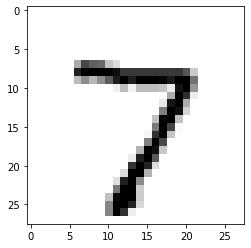

In [3]:
import matplotlib.pyplot as plt
print(model.predict(test_images[0:1]).argmax())

plt.imshow(raw_test_images[0], cmap=plt.cm.binary)
plt.show()

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_loss, test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0642 - accuracy: 0.9811
0.06418932229280472 0.9811000227928162


In [5]:
class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation
        
        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)
        
        b_shape = (output_size, )
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)
        
    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)
    
    @property
    def weights(self):
        return [self.W, self.b]
    

class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x
    
    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights += layer.weights
        return weights
    
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

In [6]:
naive_model = NaiveSequential([
    NaiveDense(input_size=28*28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])

def update_weights(gradients, weights):
    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    optimizer.apply_gradients(zip(gradients, weights))
#     for g, w in zip(gradients, weights):
#         w.assign_sub(g * learning_rate)
        

def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss



def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels, batch_size)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")


fit(naive_model, train_images, train_labels, 10, batch_size=128)

Epoch 0
loss at batch 0: 6.24
loss at batch 100: 1.87
loss at batch 200: 1.64
loss at batch 300: 1.60
loss at batch 400: 0.32
Epoch 1
loss at batch 0: 0.21
loss at batch 100: 0.14
loss at batch 200: 0.17
loss at batch 300: 0.17
loss at batch 400: 0.46
Epoch 2
loss at batch 0: 0.19
loss at batch 100: 0.11
loss at batch 200: 0.17
loss at batch 300: 0.15
loss at batch 400: 0.32
Epoch 3
loss at batch 0: 0.14
loss at batch 100: 0.09
loss at batch 200: 0.16
loss at batch 300: 0.17
loss at batch 400: 0.36
Epoch 4
loss at batch 0: 0.13
loss at batch 100: 0.06
loss at batch 200: 0.18
loss at batch 300: 0.20
loss at batch 400: 0.32
Epoch 5
loss at batch 0: 0.13
loss at batch 100: 0.08
loss at batch 200: 0.18
loss at batch 300: 0.31
loss at batch 400: 0.26
Epoch 6
loss at batch 0: 0.13
loss at batch 100: 0.05
loss at batch 200: 0.14
loss at batch 300: 0.19
loss at batch 400: 0.27
Epoch 7
loss at batch 0: 0.13
loss at batch 100: 0.00
loss at batch 200: 0.13
loss at batch 300: 0.13
loss at batch 40

In [7]:
import numpy as np

predictions = naive_model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

accuracy: 0.97
